# <center>Training a Decentralized Machine Learning Model</center>

In this phase, we will train a decentralized machine learning (ML) model using Horizontal Federated Learning (HFL), where five clients collaboratively train a model on fraud transaction data without sharing their raw data. Each client retains its dataset locally, and only model updates are exchanged, ensuring privacy and compliance with data protection regulations.

Unlike centralized ML, where data is aggregated in a single location, HFL addresses privacy concerns, data silos, and regulatory constraints. After benchmarking the centralized model, we will compare its performance, efficiency, and trade-offs against the federated approach to assess its viability in fraud detection.

--- 

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

torch: 2.6.0
flwr : 1.14.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../")

import ray

import torch
import torch.nn as nn

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg 
from flwr.simulation import run_simulation 

from src.paths import DATA_DIR
from src.config import NUM_CLASSES, NUM_FEATURES, SERVER_CONFIG
from src.train_decentralized import train_model
from src.FL_client import BankFLClient
from src.FL_server import weighted_average, evaluate, evaluate_transformer
from src.local_utility import load_client_data, load_test_data, get_weights, set_weights
from src.local_utility import set_device, set_seed

------

In [3]:
DEVICE = set_device()
set_seed()

torch.manual_seed(42)

In [4]:
# Load Datasets
num_clients = SERVER_CONFIG['num_clients']
train_sets = []
val_sets = []

for i in range(num_clients):
    train_set, val_set = load_client_data(i)
    train_sets.append(train_set)
    val_sets.append(val_set)

test_set = load_test_data()

------

In [5]:
# Define Model 

class FraudDetectionModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(

            # 1st hidden layer
            nn.Linear(num_features, 25),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(25, 15),
            nn.ReLU(),

            # output layer
            nn.Linear(15, num_classes)
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

----

In [6]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES) # initialize model
    client_train = train_sets[partition_id] #<-- Assign partitioned training dataset
    client_val = val_sets[partition_id]     #<-- Assign partitioned validation dataset
    
    return BankFLClient(model, client_train, client_val).to_client()

client = ClientApp(client_fn)

In [7]:
model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
params = ndarrays_to_parameters(get_weights(model))

def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=evaluate,             #<--- Global evaluation function
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )

    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=SERVER_CONFIG['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default, allocate to each client 1x CPU and 0x GPUs. However, when running on GPU, assign an entire GPU for each client

In [8]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": False
    },
    "client_resources": {
        "num_cpus": 1, 
        "num_gpus": 0.0
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-03-25 17:52:51,241	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-25 17:52:51,372	INFO packaging.py:575 -- Creating a file package for local module 'C:\Users\Emeka Obiefuna\Desktop\Data Science\Personal Projects\MLC - Research Work\MLC-FedML'.
2025-03-25 17:52:51,507	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_82eca55f28d09170.zip' (2.21MiB) to Ray cluster...
2025-03-25 17:52:51,524	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_82eca55f28d09170.zip'.
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.7135769834323805, {'accuracy': 0.3485881207400195}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 


Accuracy: 0.80 | Recall: 0.73 | Precision: 0.71 | ROC-AUC: 0.86 | Recall 1%-FPR: 0.14 | Recall 5%-FPR: 0.45

 ___________________________________________________________________________________________________ 



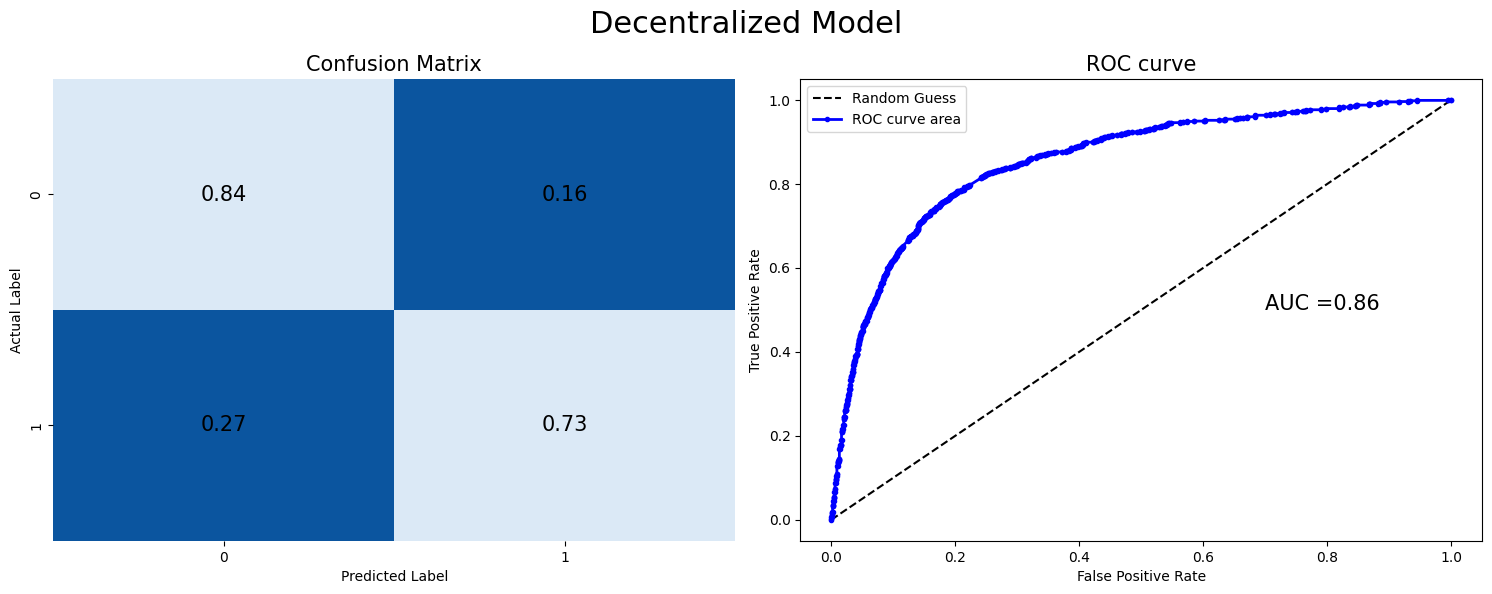

INFO :      fit progress: (20, 0.5187118807617499, {'accuracy': 0.8020123336579033}, 148.08695040014572)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


___________________________________________________________________________________________________ 

Federated Learning Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2007
           1       0.71      0.73      0.72      1074

    accuracy                           0.80      3081
   macro avg       0.78      0.79      0.78      3081
weighted avg       0.80      0.80      0.80      3081

___________________________________________________________________________________________________


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 148.41s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4190720879217655
INFO :      		round 2: 0.41419617947360127
INFO :      		round 3: 0.41878203829210736
INFO :      		round 4: 0.4197345606341749
INFO :      		round 5: 0.41960557599539994
INFO :      		round 6: 0.4332243362496515
INFO :      		round 7: 0.4319240607769963
INFO :      		round 8: 0.4323050702316054
INFO :      		round 9: 0.4430988958144927
INFO :      		round 10: 0.4469428915991235
INFO :      		round 11: 0.44730902075308965
INFO :      		round 12: 0.45516226764371454
INFO :      		round 13: 0.4561863054438949
INFO :      		round 14: 0.4702559608954021
INFO :      		round 15: 0.47777079511668935
INFO :      		round 16: 0.4791398479810304
INFO :      		round 17: 0.478832241344343
INFO :      		round 18: 0.48251282327038625
INFO :      		round 19: 0.514854234484

In [9]:
project_root =  os.path.abspath("..")
data_dir = os.path.abspath(DATA_DIR)

ray.shutdown()

ray.init(runtime_env={"working_dir": project_root, 'excludes': ['data', '.git']})

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = SERVER_CONFIG.get("num_clients"), #<-- number of clients (5)
    backend_config=backend_setup
)

----

----

<br><p>

## Federated Transformer

<br><p> 

Let's now explore the integration of transformer-based model into federated learning frameworks to see if it can enhance performance on our non-IID financial data, addressing challenges in privacy-preserving fraud detection.

---- 

In [10]:
from src.local_utility import TransformerModel
from src.config import INPUT_DIM, NUM_CLASSES, NUM_HEADS, NUM_LAYERS, DROPOUT, DIM_FEEDFORWARD

In [11]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, num_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_feedforward, 
            nhead=num_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=True  # Set batch_first to True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer_encoder(x)
        x = x.squeeze(1)  # Remove sequence dimension
        x = self.fc(x)
        return x #torch.sigmoid(x)

# Hyperparameters
# input_dim = 51 #X_train.shape[1]
# num_classes = 2
# num_heads = 8
# num_layers = 2
# dim_feedforward = 64
# dropout = 0.1

----

In [12]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    # initialize model
    transformer_model =TransformerModel(INPUT_DIM, NUM_CLASSES, NUM_HEADS, NUM_LAYERS, DIM_FEEDFORWARD, DROPOUT)
    client_train = train_sets[partition_id] #<-- Assign partitioned training dataset
    client_val = val_sets[partition_id]     #<-- Assign partitioned validation dataset
    
    return BankFLClient(transformer_model, client_train, client_val).to_client()

client = ClientApp(client_fn)

In [13]:
transformer_model= TransformerModel(INPUT_DIM, NUM_CLASSES, NUM_HEADS, NUM_LAYERS, DIM_FEEDFORWARD, DROPOUT)

params = ndarrays_to_parameters(get_weights(transformer_model))

def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=evaluate_transformer,             #<--- Global evaluation function
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )

    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=SERVER_CONFIG['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

In [14]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": False
    },
    "client_resources": {
        "num_cpus": 1, 
        "num_gpus": 0.0
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-03-25 17:57:49,360	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-25 17:57:49,461	INFO packaging.py:575 -- Creating a file package for local module 'C:\Users\Emeka Obiefuna\Desktop\Data Science\Personal Projects\MLC - Research Work\MLC-FedML'.
2025-03-25 17:57:49,569	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_6acfdab5008b1934.zip' (2.12MiB) to Ray cluster...
2025-03-25 17:57:49,580	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_6acfdab5008b1934.zip'.
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.6570925822063368, {'accuracy': 0.5913664394677053}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 


Accuracy: 0.81 | Recall: 0.73 | Precision: 0.72 | ROC-AUC: 0.87 | Recall 1%-FPR: 0.24 | Recall 5%-FPR: 0.52

 ___________________________________________________________________________________________________ 



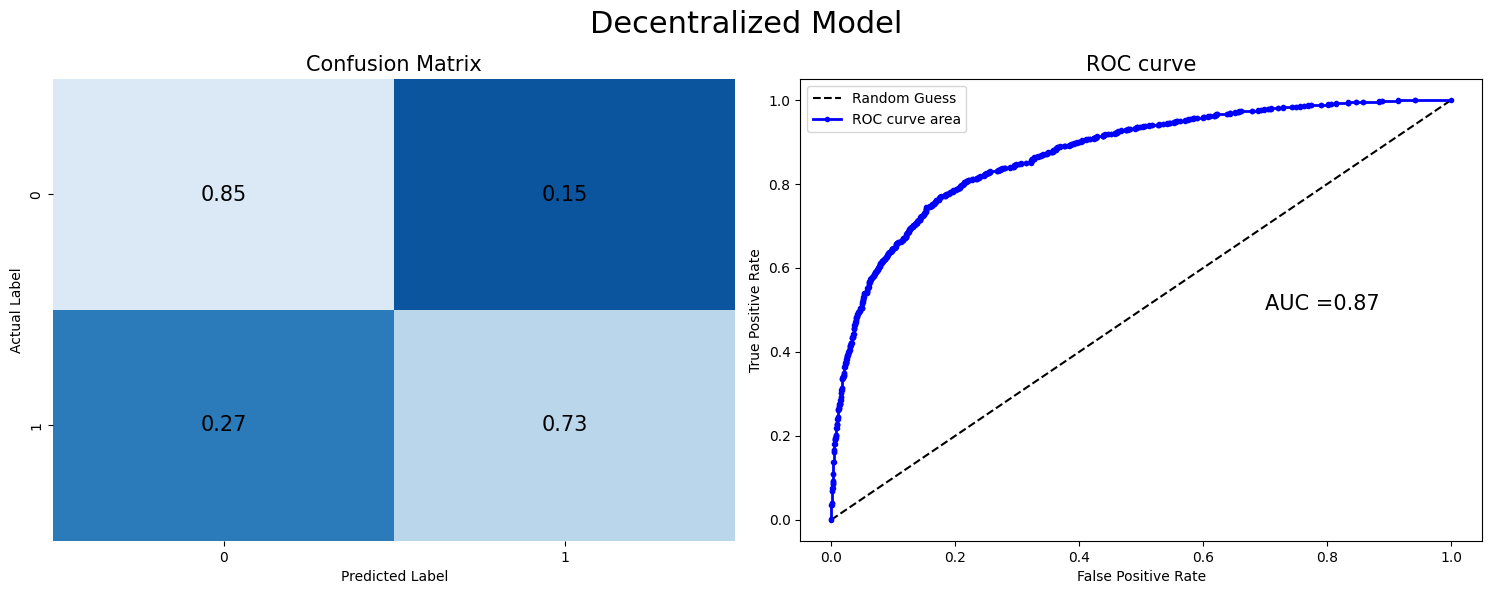

INFO :      fit progress: (20, 0.4334824535311485, {'accuracy': 0.8078545926647193}, 674.729146100115)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


___________________________________________________________________________________________________ 

Federated Learning Classification Report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2007
           1       0.72      0.73      0.73      1074

    accuracy                           0.81      3081
   macro avg       0.79      0.79      0.79      3081
weighted avg       0.81      0.81      0.81      3081

___________________________________________________________________________________________________


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 675.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4715948122054113
INFO :      		round 2: 0.41401459629845105
INFO :      		round 3: 0.40869151577237045
INFO :      		round 4: 0.4073465725199298
INFO :      		round 5: 0.41756988278412405
INFO :      		round 6: 0.4069247818955169
INFO :      		round 7: 0.40683529421477554
INFO :      		round 8: 0.40784916905044777
INFO :      		round 9: 0.4086080510159565
INFO :      		round 10: 0.4077455388702929
INFO :      		round 11: 0.40542303903599547
INFO :      		round 12: 0.4111880392162169
INFO :      		round 13: 0.4123007323075388
INFO :      		round 14: 0.40992554895063044
INFO :      		round 15: 0.4049949052839481
INFO :      		round 16: 0.4063298581858048
INFO :      		round 17: 0.41047940796664567
INFO :      		round 18: 0.407269353594455
INFO :      		round 19: 0.40817609162

In [15]:
project_root =  os.path.abspath("..")

ray.shutdown()

ray.init(runtime_env={"working_dir": project_root, 'excludes': ['data', '.git']})

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = SERVER_CONFIG.get("num_clients"), #<-- number of clients (5)
    backend_config=backend_setup
)